In [1]:
!kaggle datasets download -d muhammad4hmed/monkeypox-patients-dataset
#if alr exist
!rm "DATA.csv"

!unzip "monkeypox-patients-dataset.zip"
!rm "monkeypox-patients-dataset.zip"

'kaggle' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import pandas as pd
import numpy as np
import pickle as pkl

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score


In [3]:
# Reading data
df = pd.read_csv("DATA.csv")
df.head()

,Patient_ID,Systemic Illness,Rectal Pain,Sore Throat,Penile Oedema,Oral Lesions,Solitary Lesion,Swollen Tonsils,HIV Infection,Sexually Transmitted Infection,MonkeyPox
0,P0,NaN,False,True,True,True,False,True,False,False,Negative
1,P1,Fever,True,False,True,True,False,False,True,False,Positive
2,P2,Fever,False,True,True,False,False,False,True,False,Positive
3,P3,NaN,True,False,False,False,True,True,True,False,Positive
4,P4,Swollen Lymph Nodes,True,True,True,False,False,True,True,False,Positive


#EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Patient_ID                      25000 non-null  object
 1   Systemic Illness                18784 non-null  object
 2   Rectal Pain                     25000 non-null  bool  
 3   Sore Throat                     25000 non-null  bool  
 4   Penile Oedema                   25000 non-null  bool  
 5   Oral Lesions                    25000 non-null  bool  
 6   Solitary Lesion                 25000 non-null  bool  
 7   Swollen Tonsils                 25000 non-null  bool  
 8   HIV Infection                   25000 non-null  bool  
 9   Sexually Transmitted Infection  25000 non-null  bool  
 10  MonkeyPox                       25000 non-null  object
dtypes: bool(8), object(3)
memory usage: 781.4+ KB


In [5]:
# Check duplicated rows
df.duplicated().sum()

0

In [6]:
# Check null values
df.isnull().sum()

Patient_ID                           0
Systemic Illness                  6216
Rectal Pain                          0
Sore Throat                          0
Penile Oedema                        0
Oral Lesions                         0
Solitary Lesion                      0
Swollen Tonsils                      0
HIV Infection                        0
Sexually Transmitted Infection       0
MonkeyPox                            0
dtype: int64

There are no duplicate data and no null values except in the 'Systemic Illness' column, where null refers to no systemic illness (will be handled later on).

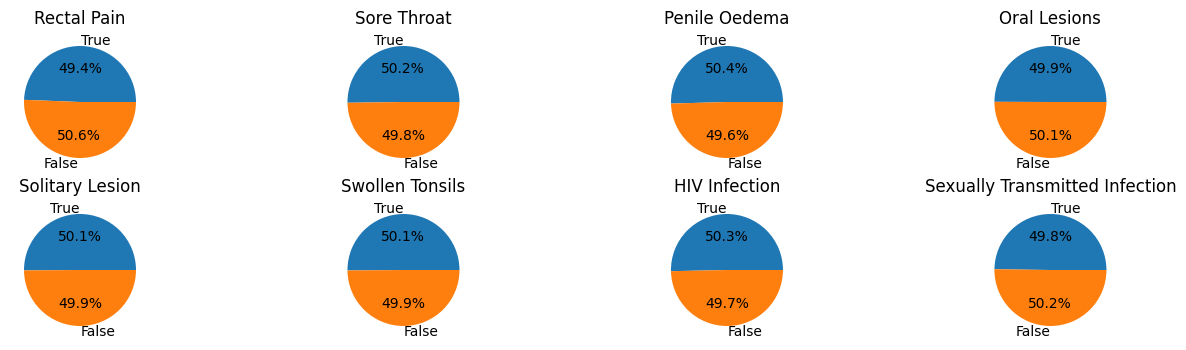

In [7]:
boolean_columns = ['Rectal Pain', 'Sore Throat', 'Penile Oedema', 'Oral Lesions', 'Solitary Lesion',
                   'Swollen Tonsils', 'HIV Infection', 'Sexually Transmitted Infection']
labels = ['True', 'False']

plt.figure(figsize=(16,4))
for i, col in enumerate(boolean_columns):
  # print(df[col].value_counts())
  values = [len(df[df[col]==True]), len(df[df[col]==False])]
  plt.subplot(2, 4, i+1)
  plt.pie(values, labels = labels, autopct='%1.1f%%')
  plt.title(col)

plt.show()

Distribution of features are fair, no certain quality of feature outnumbering the others.

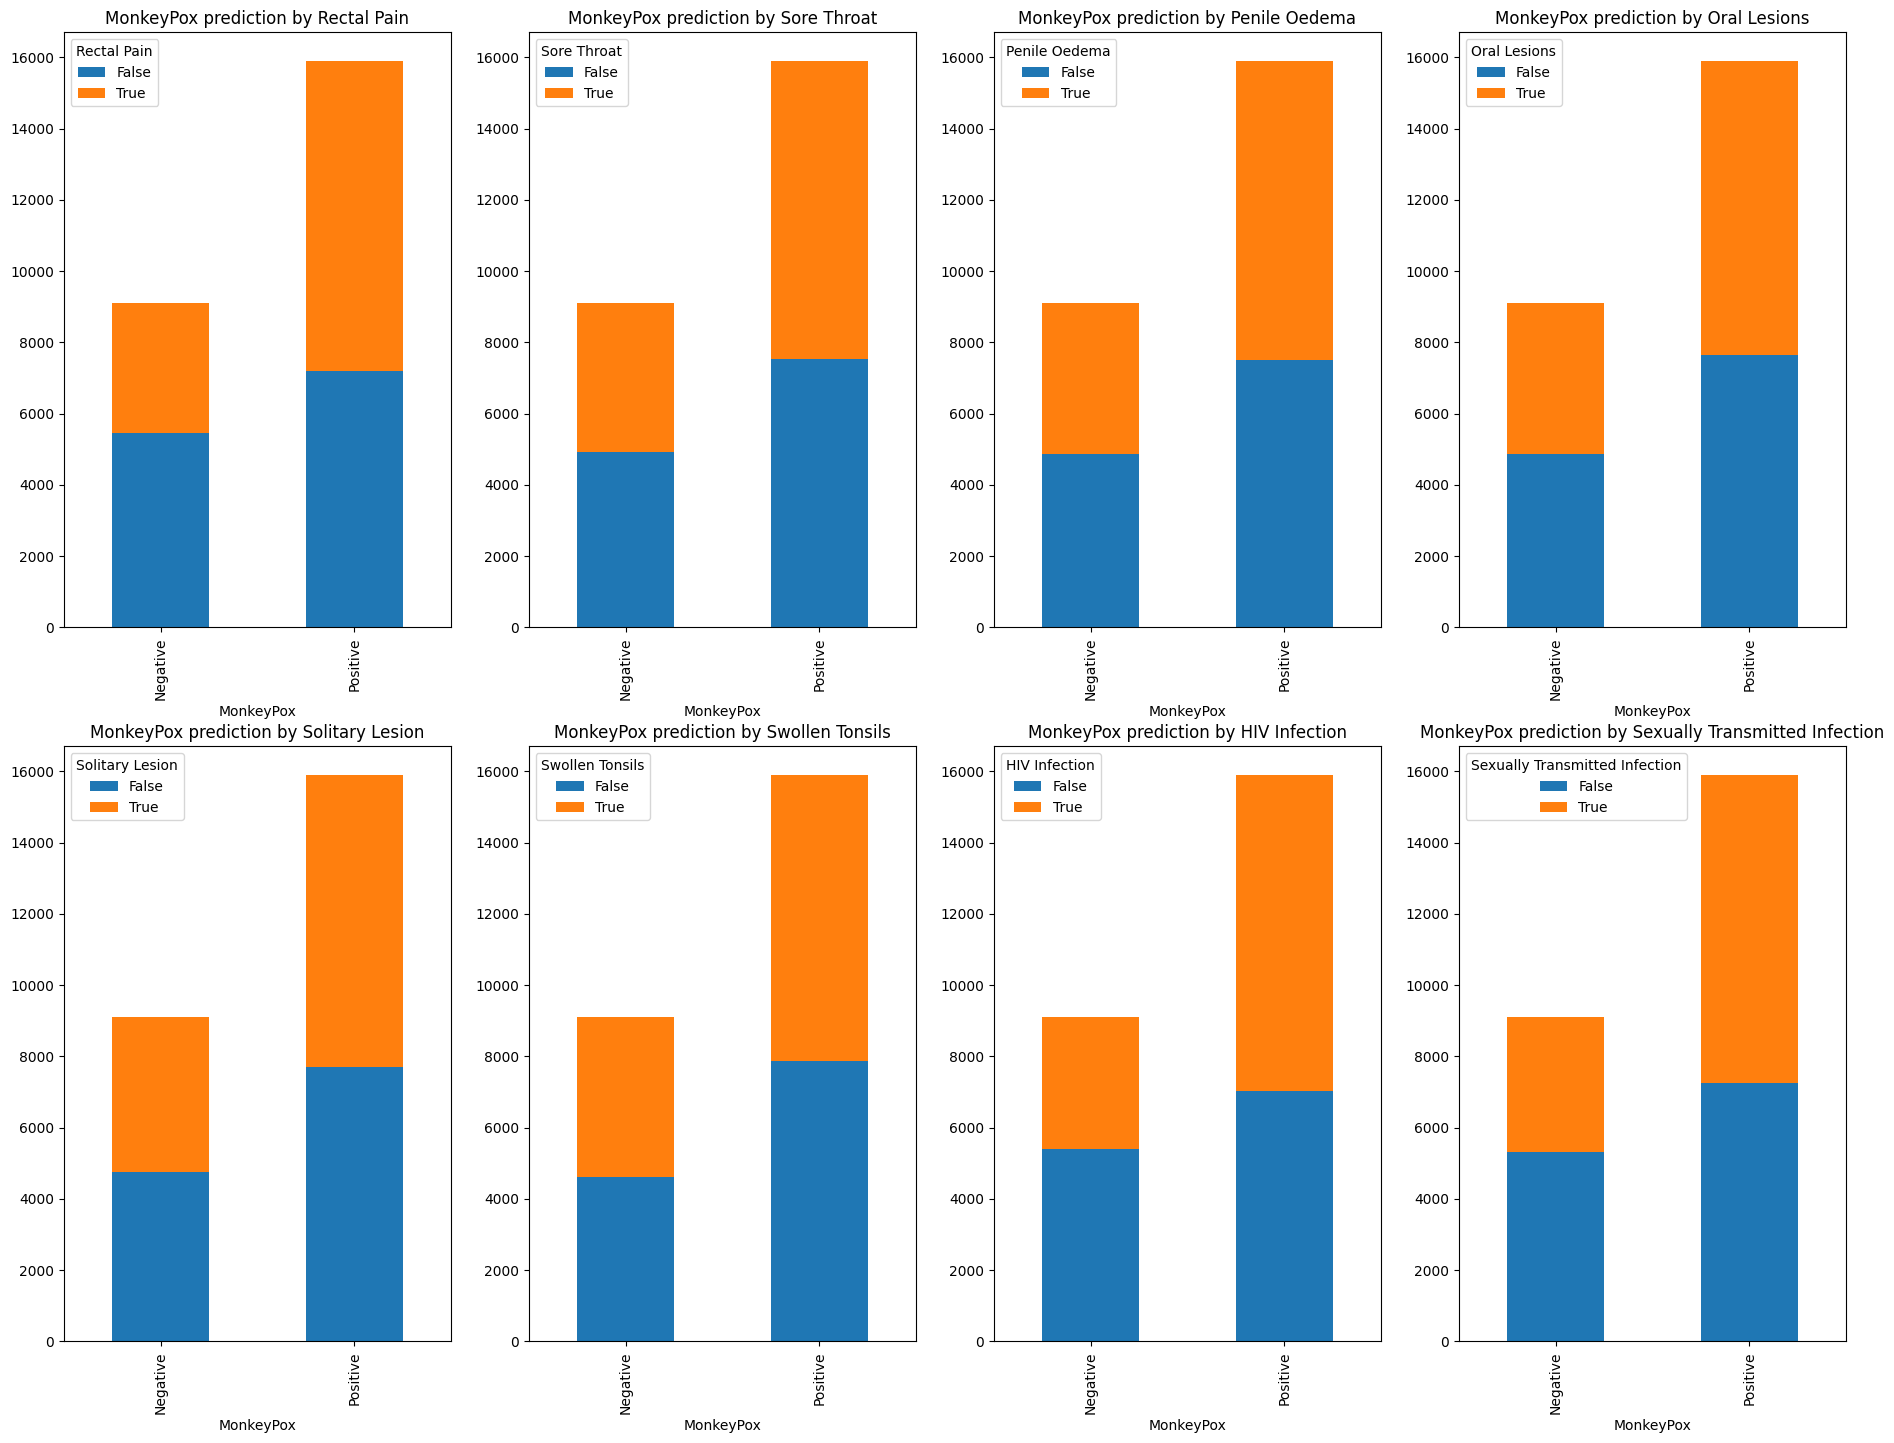

In [8]:
plt.figure(figsize=(23,17))
for i, col in enumerate(boolean_columns):
    grouped_data = df.groupby(['MonkeyPox', col]).size().unstack(fill_value=0)
    ax = plt.subplot(2, 4, i+1)
    grouped_data.plot(kind='bar', stacked=True, ax=ax)
    plt.title(f'MonkeyPox prediction by {col}')
plt.show()

No significant correlation between features and monkeypox prediction but overall, it shows that the existence of symptoms makes a higher probability for Monkeypox. We might need to create a new feature later on (e.g. create sum column which represents the total number of symptoms)

In [9]:
# Fill in null values for categorical data -> None for no systemic illness
df['Systemic Illness'].fillna('None', inplace=True)

Systemic Illness
Fever                    6382
Swollen Lymph Nodes      6252
None                     6216
Muscle Aches and Pain    6150
Name: count, dtype: int64


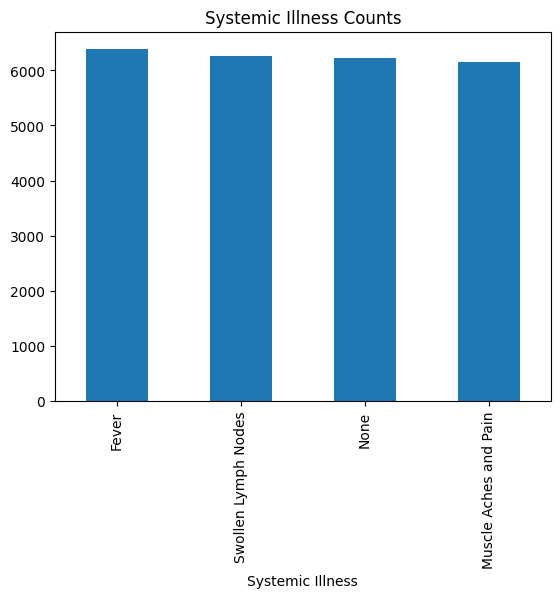

In [10]:
# Frequency of each illness
illness_counts = df['Systemic Illness'].value_counts(dropna=False)
print(illness_counts)

# Bar plot of systemic illness
illness_counts.plot(kind='bar')
plt.title('Systemic Illness Counts')
plt.show()

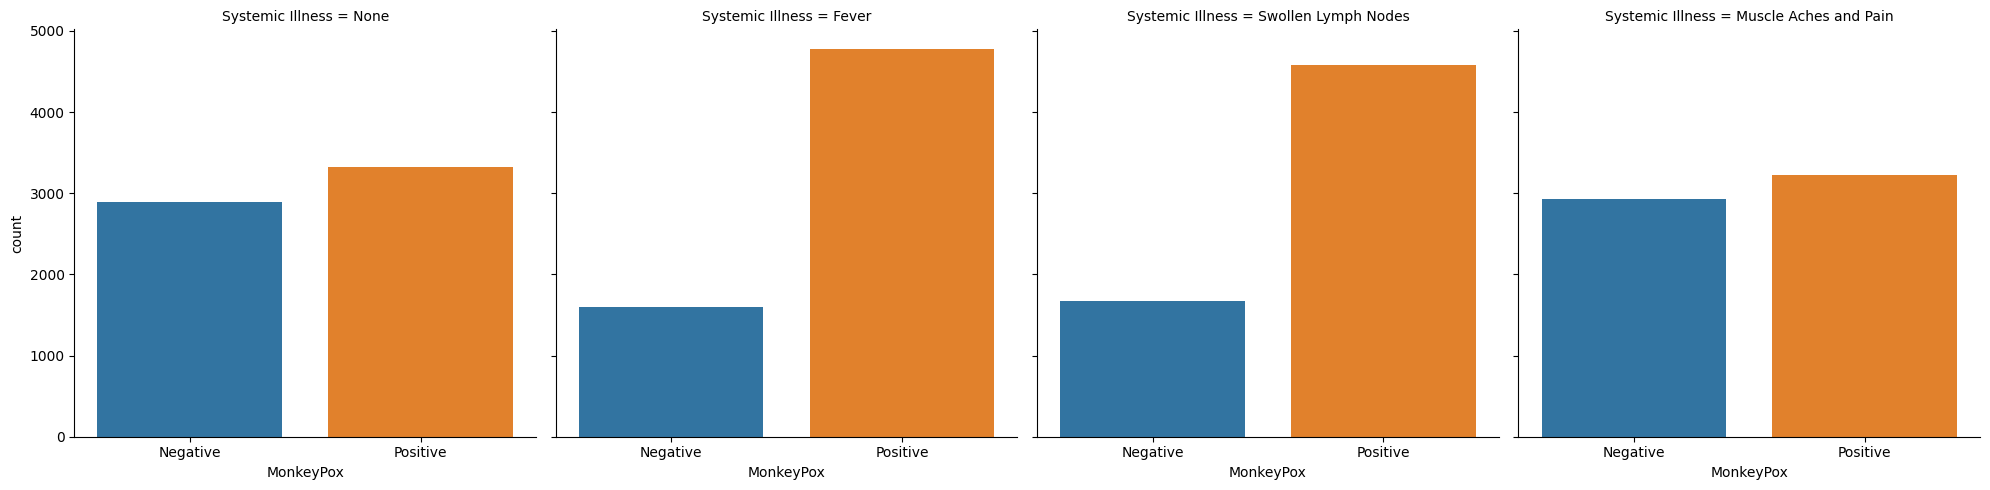

In [11]:
sns.catplot(x='MonkeyPox', col='Systemic Illness', data=df, kind='count')
plt.show()

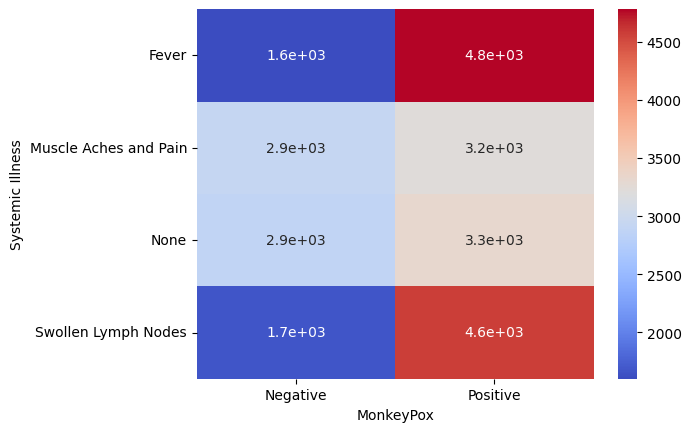

In [12]:
# Relationship between systemic illness and MonkeyPox
illness_crosstab = pd.crosstab(df['Systemic Illness'], df['MonkeyPox'])
sns.heatmap(illness_crosstab, annot=True, cmap='coolwarm')
plt.show()

'Muscle Aches and Pain' and 'None' shows less significance to the prediction of Monkeypox, while the existence of symptom 'Fever' and 'Swollen Lymph Nodes' show correlation to the existence of Monkeypox.

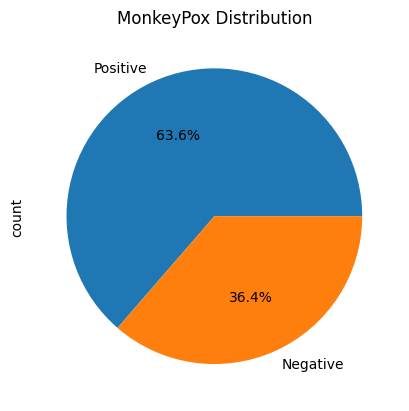

In [13]:
#Data distribution
df['MonkeyPox'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('MonkeyPox Distribution')
plt.show()

Data is not balanced between positive Monkeypox and negative Monkeypox, will have to do balancing for the dataset.

#Preprocessing

In [14]:
# Drop irrelevant column
df.drop(columns=['Patient_ID'], inplace=True)

In [15]:
# Encoding categorical values (Systemic Illness)
encoded_data = pd.get_dummies(df['Systemic Illness'], prefix='Systemic Illness')
df = pd.concat([df, encoded_data], axis=1)
df = df.drop(['Systemic Illness', 'Systemic Illness_None'], axis=1)
df.head()

,Rectal Pain,Sore Throat,Penile Oedema,Oral Lesions,Solitary Lesion,Swollen Tonsils,HIV Infection,Sexually Transmitted Infection,MonkeyPox,Systemic Illness_Fever,Systemic Illness_Muscle Aches and Pain,Systemic Illness_Swollen Lymph Nodes
0,False,True,True,True,False,True,False,False,Negative,False,False,False
1,True,False,True,True,False,False,True,False,Positive,True,False,False
2,False,True,True,False,False,False,True,False,Positive,True,False,False
3,True,False,False,False,True,True,True,False,Positive,False,False,False
4,True,True,True,False,False,True,True,False,Positive,False,False,True


In [16]:
# Encoding binary values
mapping = {
        True: 1,
        False: 0,
        "Positive": 1,
        "Negative": 0
}
df = df.applymap(lambda x: mapping.get(x, x))
df.sample(5)

C:\Users\Asus\AppData\Local\Temp\ipykernel_15884\2829669467.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: mapping.get(x, x))


,Rectal Pain,Sore Throat,Penile Oedema,Oral Lesions,Solitary Lesion,Swollen Tonsils,HIV Infection,Sexually Transmitted Infection,MonkeyPox,Systemic Illness_Fever,Systemic Illness_Muscle Aches and Pain,Systemic Illness_Swollen Lymph Nodes
6236,1,0,0,0,1,0,1,1,1,0,0,0
21034,0,0,1,0,0,0,0,1,1,0,0,1
14001,0,1,0,0,0,0,0,0,0,0,0,0
17918,0,1,1,0,1,0,0,0,1,0,0,1
6861,0,1,1,0,0,0,0,0,0,0,0,0


In [17]:
# Create sum column for sum of symptoms
df['sum'] = df.sum(axis=1)

In [18]:
df.head()

,Rectal Pain,Sore Throat,Penile Oedema,Oral Lesions,Solitary Lesion,Swollen Tonsils,HIV Infection,Sexually Transmitted Infection,MonkeyPox,Systemic Illness_Fever,Systemic Illness_Muscle Aches and Pain,Systemic Illness_Swollen Lymph Nodes,sum
0,0,1,1,1,0,1,0,0,0,0,0,0,4
1,1,0,1,1,0,0,1,0,1,1,0,0,6
2,0,1,1,0,0,0,1,0,1,1,0,0,5
3,1,0,0,0,1,1,1,0,1,0,0,0,5
4,1,1,1,0,0,1,1,0,1,0,0,1,7


<Axes: >

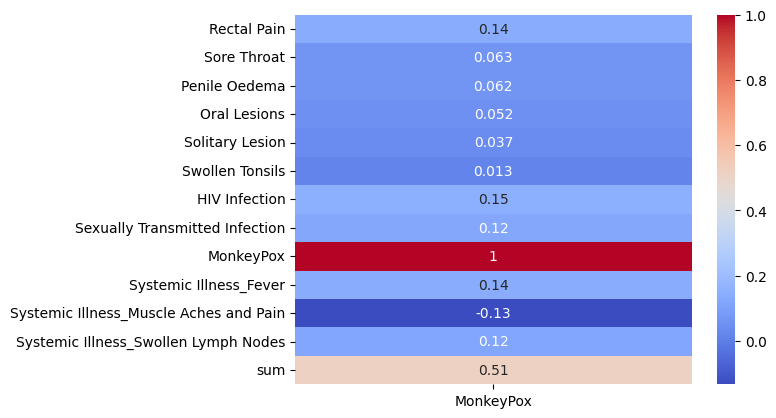

In [19]:
# Correlation mapping
# 'Sum' Column correlates well with the target column, therefore the total amount of symptoms may be an important feature.
sns.heatmap(df.corr()[['MonkeyPox']], cmap='coolwarm', annot=True)

Muscle Aches and Pain show low correlation, we try dropping them to increase model accuracy.

In [20]:
df.drop(['Systemic Illness_Muscle Aches and Pain'], axis=1, inplace=True)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype
---  ------                                --------------  -----
 0   Rectal Pain                           25000 non-null  int64
 1   Sore Throat                           25000 non-null  int64
 2   Penile Oedema                         25000 non-null  int64
 3   Oral Lesions                          25000 non-null  int64
 4   Solitary Lesion                       25000 non-null  int64
 5   Swollen Tonsils                       25000 non-null  int64
 6   HIV Infection                         25000 non-null  int64
 7   Sexually Transmitted Infection        25000 non-null  int64
 8   MonkeyPox                             25000 non-null  int64
 9   Systemic Illness_Fever                25000 non-null  int64
 10  Systemic Illness_Swollen Lymph Nodes  25000 non-null  int64
 11  sum                                   250

In [22]:
# Shuffle dataset and check for data distribution
df = shuffle(df)
df['MonkeyPox'].value_counts()

MonkeyPox
1    15909
0     9091
Name: count, dtype: int64

In [23]:
# Splitting dataset to train and test with 0.3 ratio
X = df.drop('MonkeyPox', axis = 1)
y = df['MonkeyPox']

# Random undersampling to handle unbalanced dataset and reduce overfitting (since data is highly sufficient)
rus = RandomUnderSampler(random_state=42, sampling_strategy = 'majority')
X, y = rus.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify=y)

In [24]:
print(X_train)

       Rectal Pain  Sore Throat  Penile Oedema  Oral Lesions  Solitary Lesion  \
7531             1            0              0             1                0   
5806             0            1              1             1                1   
24166            0            1              0             1                1   
16306            0            1              1             0                0   
19420            1            1              1             1                1   
...            ...          ...            ...           ...              ...   
2715             0            0              1             1                0   
13147            0            0              1             1                0   
6783             1            0              0             0                0   
23395            1            1              1             1                1   
17095            1            0              0             1                0   

       Swollen Tonsils  HIV

In [25]:
print(y_train)

7531     1
5806     1
24166    0
16306    1
19420    1
        ..
2715     0
13147    1
6783     1
23395    1
17095    0
Name: MonkeyPox, Length: 12727, dtype: int64


#Model

In [26]:
# Function for model evaluation
def model_evaluation(model_name, y_test, predictions):
  accuracy = accuracy_score(y_test, predictions)
  precision = precision_score(y_test, predictions)
  recall = recall_score(y_test, predictions)
  f1 = f1_score(y_test, predictions)
  print(f"========= {model_name.upper()} EVALUATION =========")
  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("f1_score:", f1)

  cm = confusion_matrix(y_test, predictions)
  cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
  cm_display.plot()
  plt.title('Confusion Matrix')
  plt.show()
def learning_curves(model):
  train_sizes = np.linspace(0.1, 0.9, 9)
  train_scores = []
  test_scores = []
  for train_size in train_sizes:
      X_train_part, _, y_train_part, _ = train_test_split(X_train, y_train, train_size=train_size, random_state=42)
      model.fit(X_train_part, y_train_part)
      train_scores.append(accuracy_score(y_train_part, model.predict(X_train_part)))
      test_scores.append(accuracy_score(y_test, model.predict(X_test)))

  plt.figure(figsize=(10, 6))
  plt.plot(train_sizes, train_scores, label='Training Accuracy', marker='o')
  plt.plot(train_sizes, test_scores, label='Validation Accuracy', marker = 'o')
  plt.xlabel('Training Set Size')
  plt.ylabel('Accuracy')
  plt.title('Learning Curves')
  plt.legend()
  plt.ylim(0, 1.0)
  plt.show()

========= XGBOOST CLASSIFIER EVALUATION =========
Accuracy: 0.8949587534372135
Precision: 0.9142307692307692
Recall: 0.8716538320498717
f1_score: 0.8924347662849634


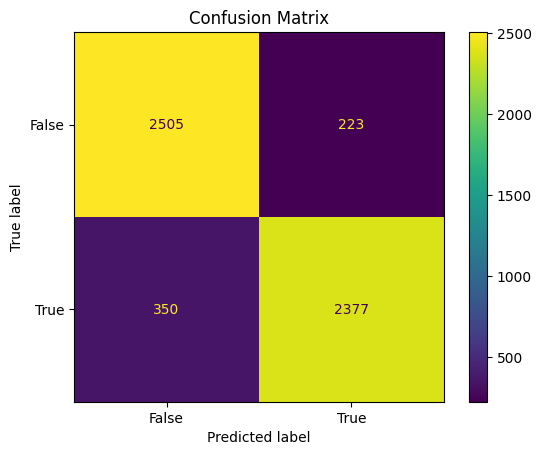

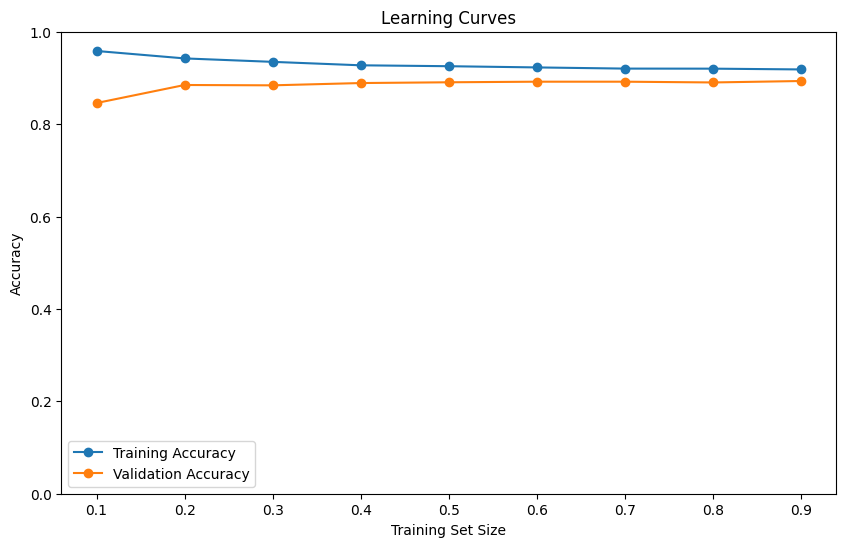

In [27]:
# Classification using XGBoost
XGBOOST_MODEL = XGBClassifier()
XGBOOST_MODEL.fit(X_train, y_train)
pred = XGBOOST_MODEL.predict(X_test)
model_evaluation("XGBOOST CLASSIFIER", y_test, pred)
learning_curves(XGBOOST_MODEL)

========= DECISION TREE EVALUATION =========
Accuracy: 0.8914757103574702
Precision: 0.911685306594678
Recall: 0.8668866886688669
f1_score: 0.8887218045112782


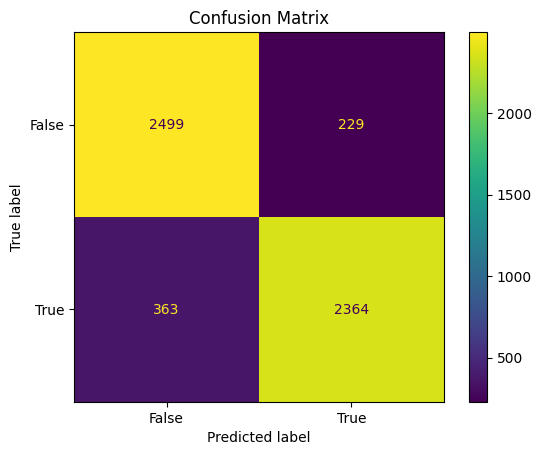

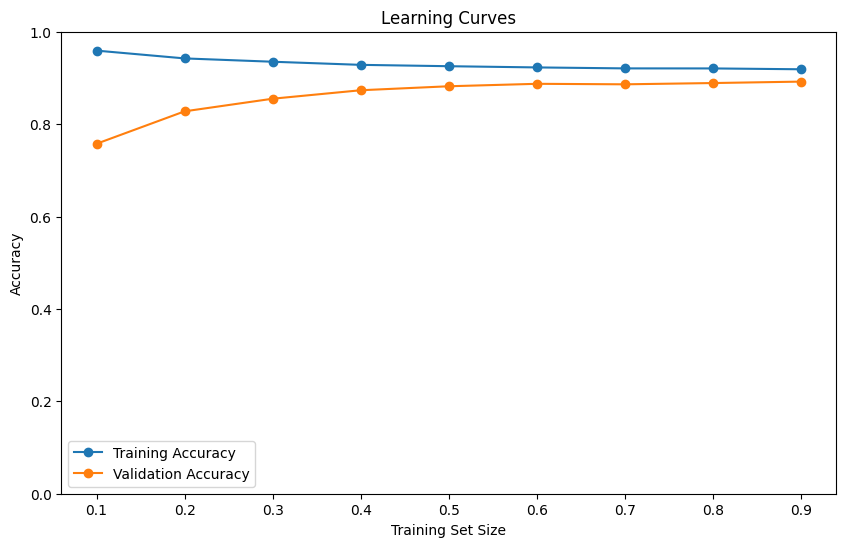

In [28]:
# Classification using Decision Tree
DecisionTree = DecisionTreeClassifier()
DecisionTree.fit(X_train, y_train)
pred = DecisionTree.predict(X_test)
model_evaluation("Decision Tree", y_test, pred)
learning_curves(DecisionTree)

========= RANDOM FOREST EVALUATION =========
Accuracy: 0.8863428047662695
Precision: 0.8998102466793169
Recall: 0.8694536120278694
f1_score: 0.8843715031704588


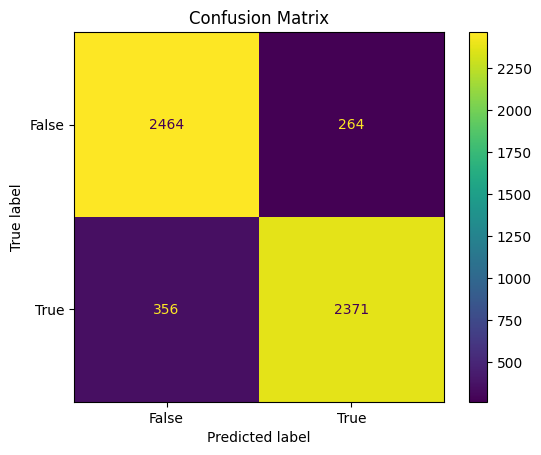

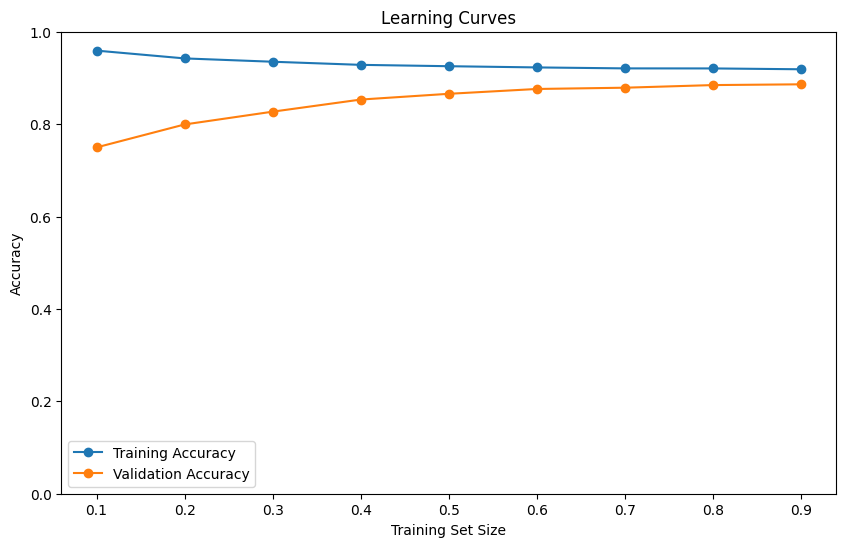

In [29]:
# Classification using Random Forest
RandomForest = RandomForestClassifier(n_estimators= 1000, random_state=42)
RandomForest.fit(X_train, y_train)
pred = RandomForest.predict(X_test)
model_evaluation("Random Forest", y_test, pred)
learning_curves(RandomForest)

========= SVM CLASSIFIER EVALUATION =========
Accuracy: 0.8988084326306142
Precision: 0.9940935938209905
Recall: 0.8023469013568023
f1_score: 0.887987012987013


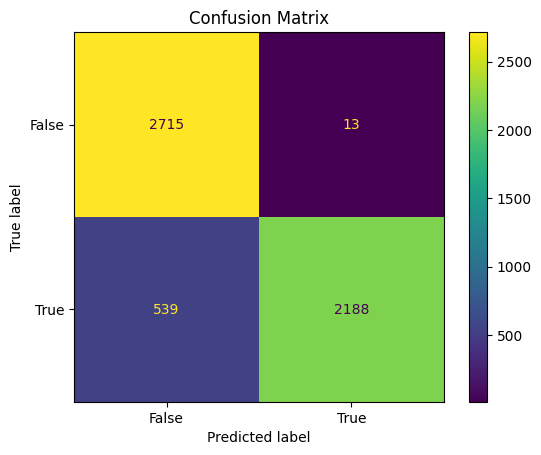

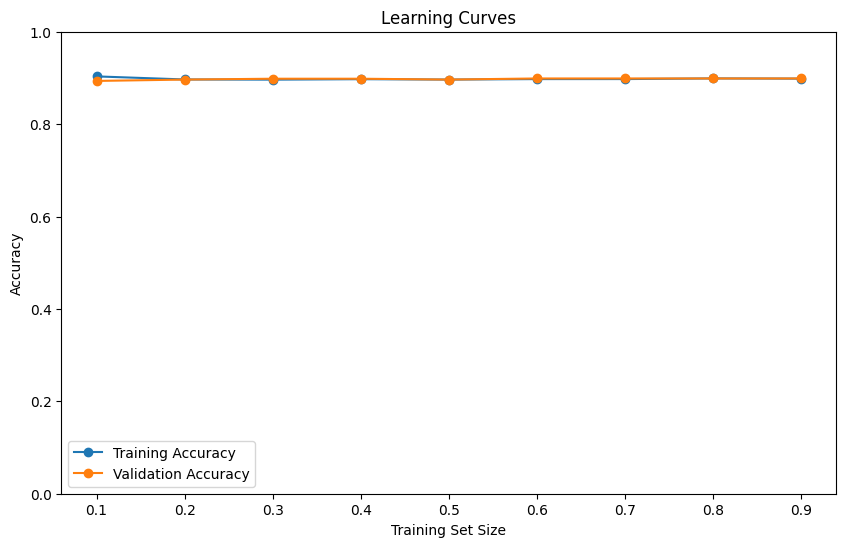

In [30]:
# Classification using Support Vector Classifier
SVM = SVC()
SVM.fit(X_train, y_train)
pred = SVM.predict(X_test)
model_evaluation("SVM Classifier", y_test, pred)
learning_curves(SVM)

========= NAIVE BAYES EVALUATION =========
Accuracy: 0.7142071494042164
Precision: 0.7070921985815602
Recall: 0.7312064539787312
f1_score: 0.7189471786551289


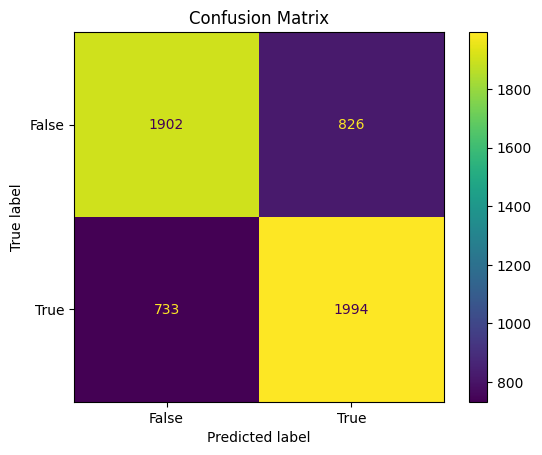

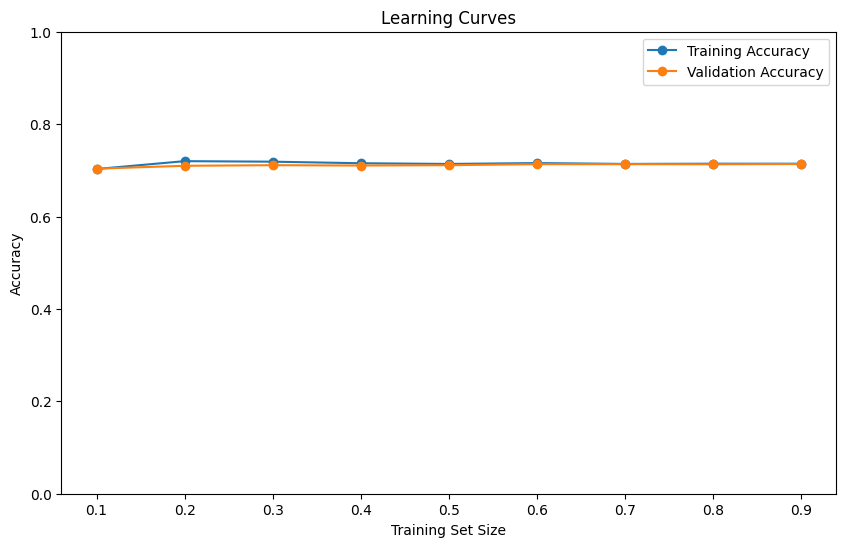

In [31]:
# Classification using Naive Bayes
NaiveBayes = GaussianNB()
NaiveBayes.fit(X_train, y_train)
pred = NaiveBayes.predict(X_test)
model_evaluation("Naive Bayes", y_test, pred)
learning_curves(NaiveBayes)

========= KNN EVALUATION =========
Accuracy: 0.8383134738771769
Precision: 0.8258565877781703
Recall: 0.8573524019068574
f1_score: 0.8413098236775818


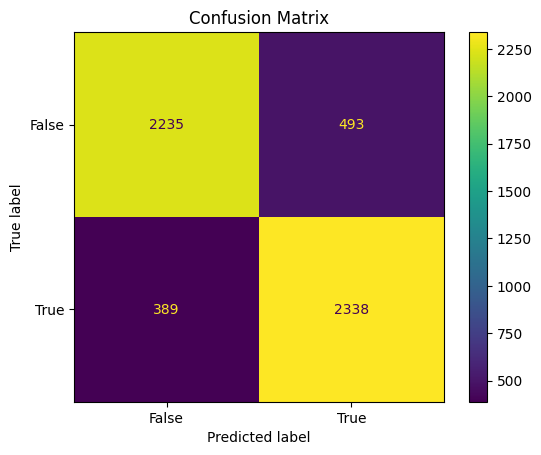

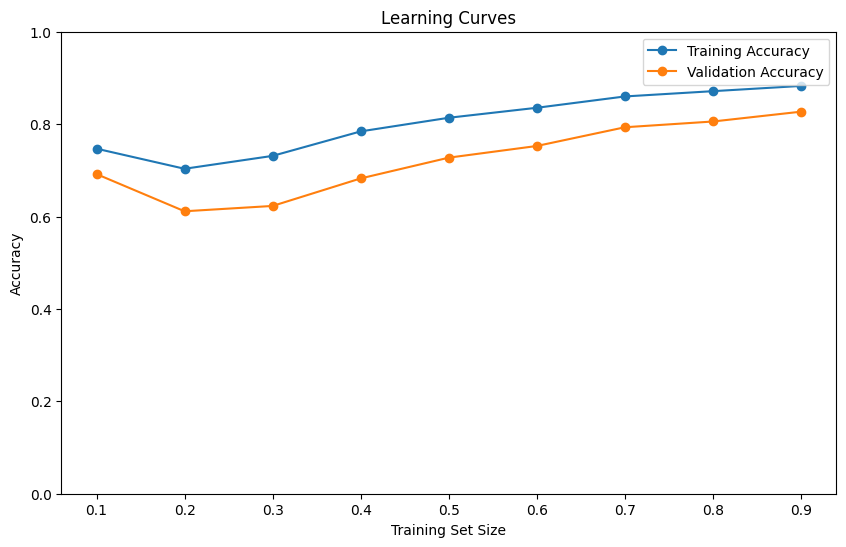

In [32]:
# Classification using K-Nearest Neighbors
KNN = KNeighborsClassifier(n_neighbors = 7, metric = 'minkowski', p = 2)
KNN.fit(X_train, y_train)
pred = KNN.predict(X_test)
model_evaluation("KNN", y_test, pred)
learning_curves(KNN)

========= LOGISTIC REGRESSION EVALUATION =========
Accuracy: 0.9081576535288726
Precision: 0.9448441247002398
Recall: 0.8668866886688669
f1_score: 0.904188181296615


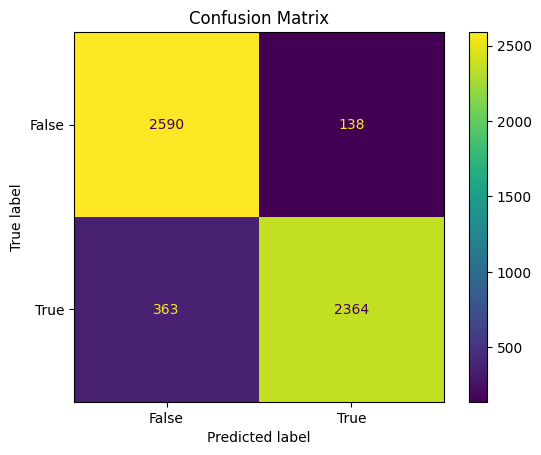

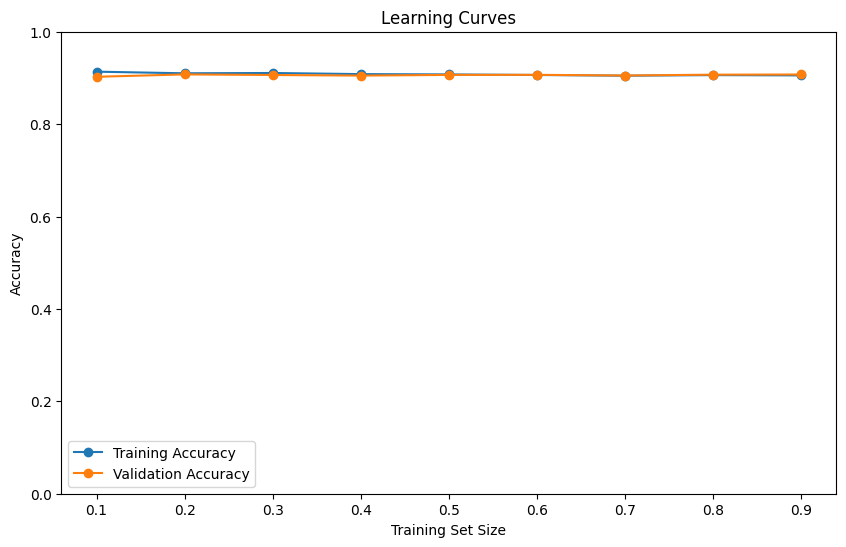

In [33]:
#Classification using Logistic Regression
LogisticReg = LogisticRegression()
LogisticReg.fit(X_train, y_train)
pred = LogisticReg.predict(X_test)
model_evaluation("Logistic Regression", y_test, pred)
learning_curves(LogisticReg)

========= L1 LOGISTIC EVALUATION =========
Accuracy: 0.906141154903758
Precision: 0.9355092410538733
Recall: 0.8723872387238724
f1_score: 0.9028462998102466


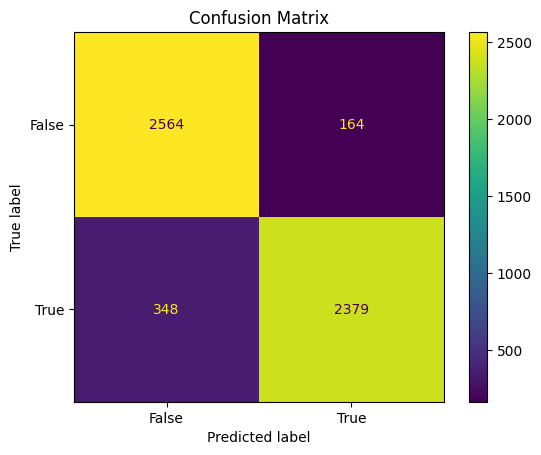

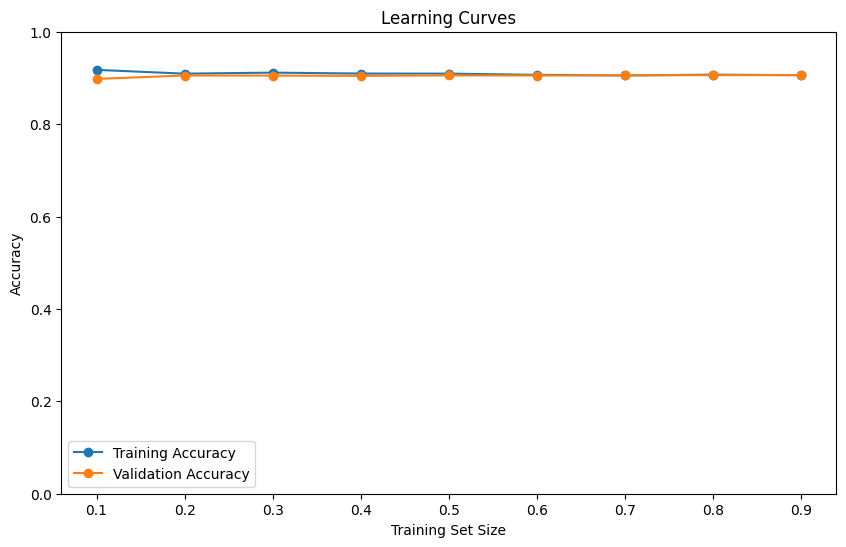

In [34]:
# L1 Regularization (Lasso) Logistic Regression
lasso_log_reg = LogisticRegression(penalty='l1', solver='saga', C=1.0, max_iter=10000)
lasso_log_reg.fit(X_train, y_train)
pred = lasso_log_reg.predict(X_test)
model_evaluation("L1 Logistic", y_test, pred)
learning_curves(lasso_log_reg)

========= L2 LOGISTIC EVALUATION =========
Accuracy: 0.9081576535288726
Precision: 0.9448441247002398
Recall: 0.8668866886688669
f1_score: 0.904188181296615


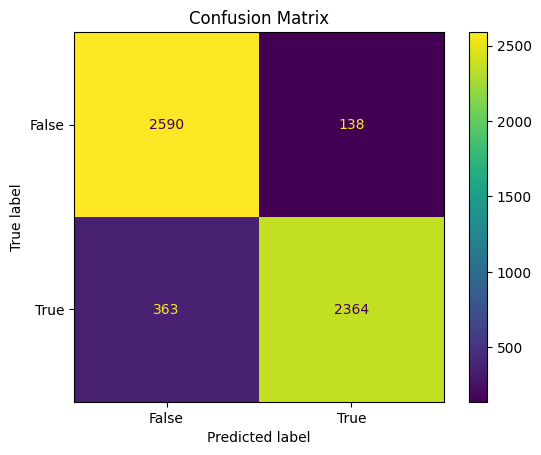

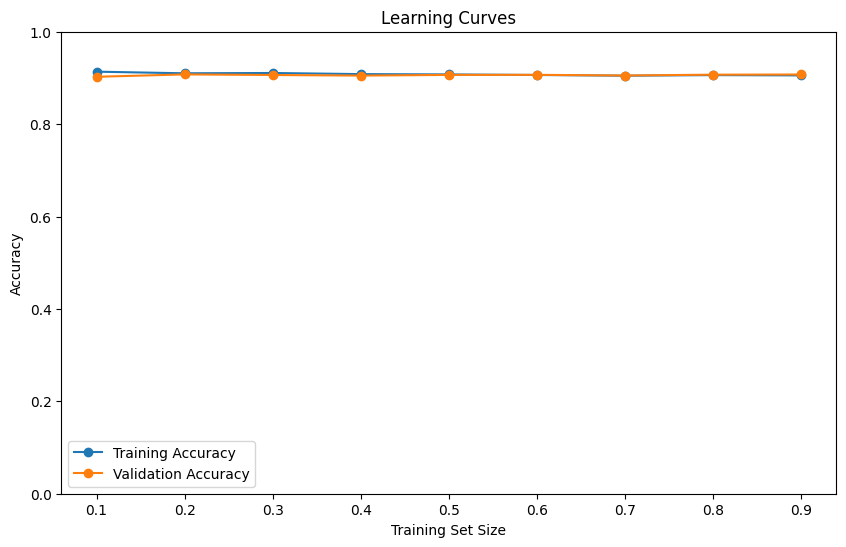

In [35]:
# L2 Regularization (Ridge) Logistic Regression
ridge_log_reg = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=10000)
ridge_log_reg.fit(X_train, y_train)
pred = ridge_log_reg.predict(X_test)
model_evaluation("L2 Logistic", y_test, pred)
learning_curves(ridge_log_reg)

========= L1+L2 LOGISTIC EVALUATION =========
Accuracy: 0.9076076993583868
Precision: 0.9412465263993648
Recall: 0.8694536120278694
f1_score: 0.9039268013724743


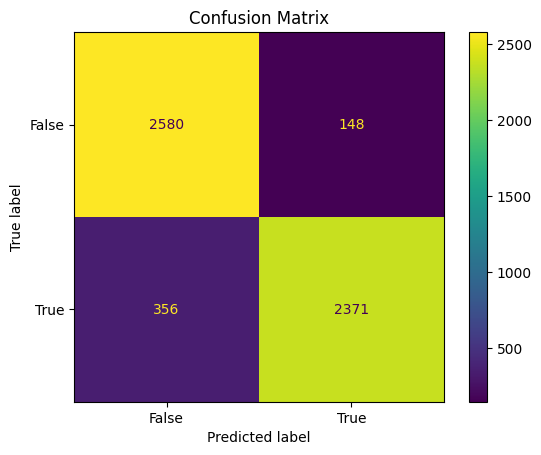

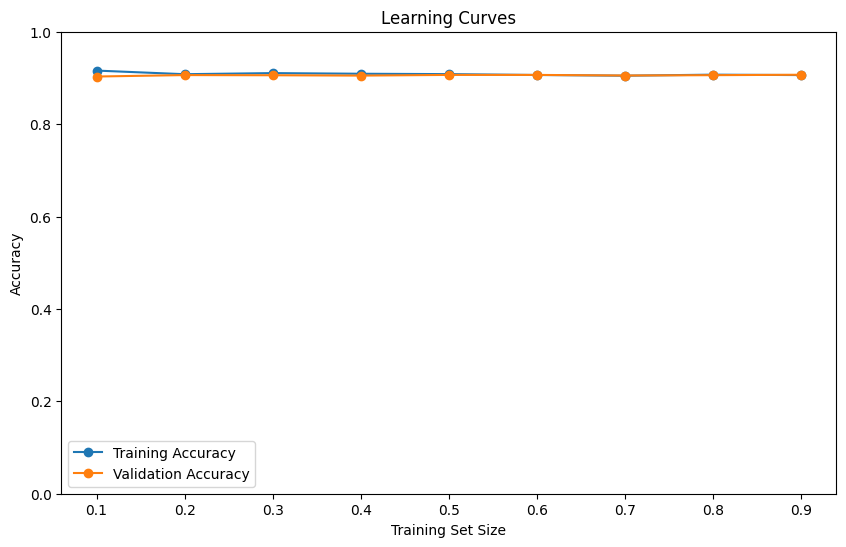

In [36]:
#L1 + L2 Regularization
elasticnet_log_reg = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, C=1.0, max_iter=10000)
elasticnet_log_reg.fit(X_train, y_train)
pred = elasticnet_log_reg.predict(X_test)
model_evaluation("L1+L2 Logistic", y_test, pred)
learning_curves(elasticnet_log_reg)

# Hyperparameter Tuning

In [37]:
param_grids = {
    'SVC': {
        'model': SVC(),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.1, 1, 10],
            'solver': ['liblinear', 'lbfgs']
        }
    },
    'XGBClassifier': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    },
    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance']
        }
    },
    'GaussianNB': {
        'model': GaussianNB(),
        'params': {
            'var_smoothing': np.logspace(-9, -6, 3)
        }
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    },
    'DecisionTreeClassifier': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    }
}

best_models = {}
for model_name, config in param_grids.items():
    grid_search = GridSearchCV(estimator=config['model'], param_grid=config['params'], cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    best_models[model_name] = {
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_,
        'best_score': grid_search.best_score_
    }
    print(f"Best Parameters for {model_name}:", grid_search.best_params_)
    print(f"Best Cross-Validation Score for {model_name}:", grid_search.best_score_)

for model_name, model_info in best_models.items():
    best_model = model_info['best_estimator']
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Set Accuracy for {model_name}: {accuracy}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters for SVC: {'C': 10, 'kernel': 'linear'}
Best Cross-Validation Score for SVC: 0.9050835163444487
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters for LogisticRegression: {'C': 10, 'solver': 'liblinear'}
Best Cross-Validation Score for LogisticRegression: 0.9061838362730861
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters for XGBClassifier: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
Best Cross-Validation Score for XGBClassifier: 0.8998978944590459
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters for KNeighborsClassifier: {'n_neighbors': 7, 'weights': 'distance'}
Best Cross-Validation Score for KNeighborsClassifier: 0.8874834904168022
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters for GaussianNB: {'var_smoothing': 1e-09}
Best Cross-Validation Score for GaussianNB: 0.7153291653612818
Fitt

Best models: Logistic Regression, SVC, XGBoost
These models might have better performance with normalized data, so we try normalizing the features.

In [38]:
# Trying normalization for features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [39]:
print(X_train_scaled)

[[ 1.05518599 -0.97877474 -0.99992143 ... -0.55765638 -0.55838283
  -0.08848496]
 [-0.94770023  1.02168554  1.00007858 ... -0.55765638  1.79088602
   1.09258277]
 [-0.94770023  1.02168554 -0.99992143 ... -0.55765638 -0.55838283
  -1.26955269]
 ...
 [ 1.05518599 -0.97877474 -0.99992143 ...  1.79321898 -0.55838283
  -1.26955269]
 [ 1.05518599  1.02168554  1.00007858 ... -0.55765638 -0.55838283
   2.86418437]
 [ 1.05518599 -0.97877474 -0.99992143 ... -0.55765638 -0.55838283
  -0.67901882]]


========= SVM CLASSIFIER EVALUATION =========
Accuracy: 0.9048579285059578
Precision: 0.9416
Recall: 0.8632196552988632
f1_score: 0.90070786301894


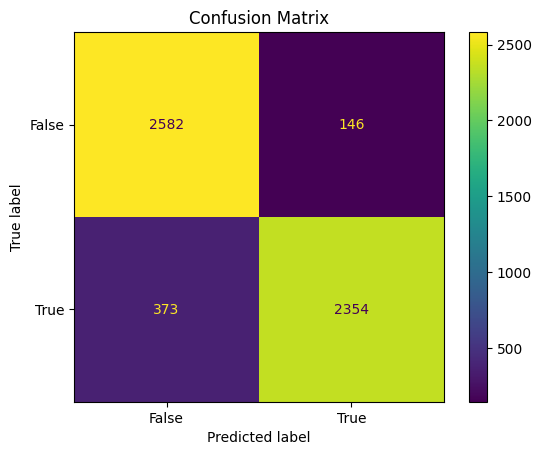

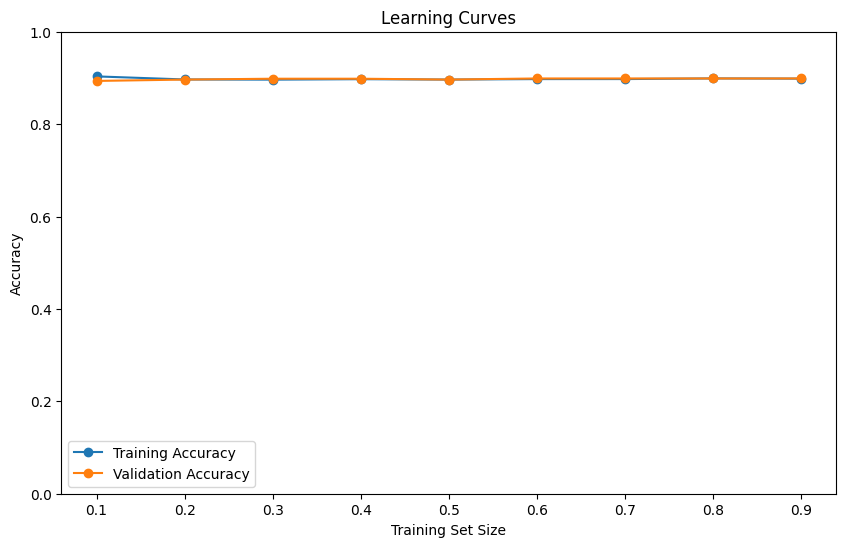

In [40]:
SVM = SVC()
SVM.fit(X_train_scaled, y_train)
pred = SVM.predict(X_test_scaled)
model_evaluation("SVM Classifier", y_test, pred)
learning_curves(SVM)

========= LOGISTIC REGRESSION EVALUATION =========
Accuracy: 0.9076076993583868
Precision: 0.944067119456652
Recall: 0.8665199853318665
f1_score: 0.9036328871892926


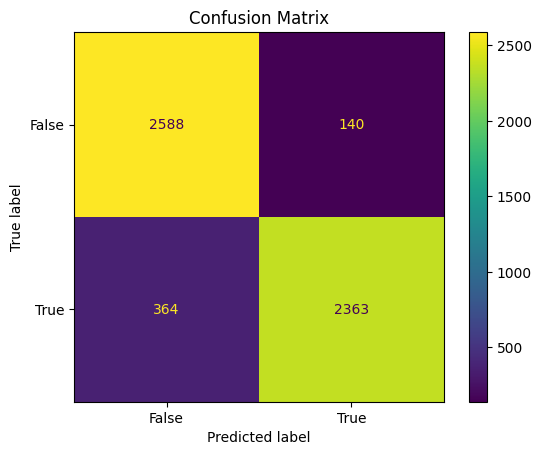

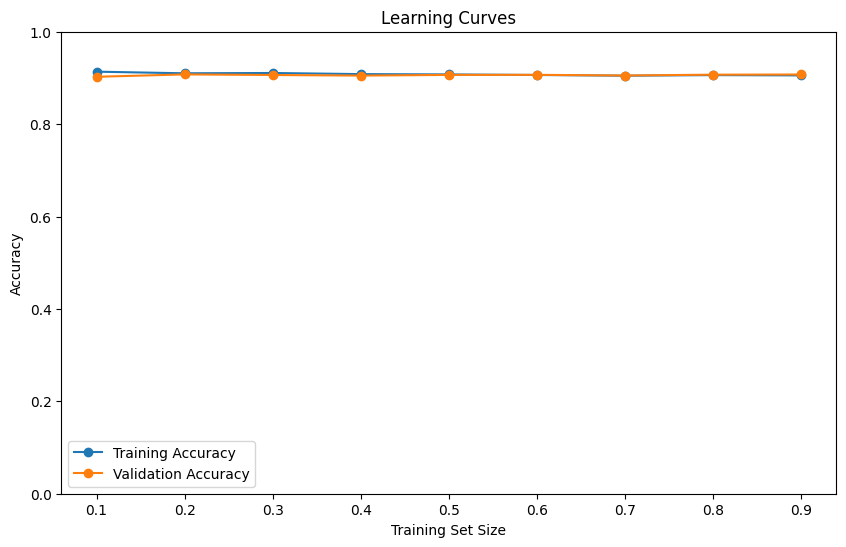

In [41]:
LogisticReg = LogisticRegression()
LogisticReg.fit(X_train_scaled, y_train)
pred = LogisticReg.predict(X_test_scaled)
model_evaluation("Logistic Regression", y_test, pred)
learning_curves(LogisticReg)

========= XGBOOST CLASSIFIER EVALUATION =========
Accuracy: 0.8949587534372135
Precision: 0.9142307692307692
Recall: 0.8716538320498717
f1_score: 0.8924347662849634


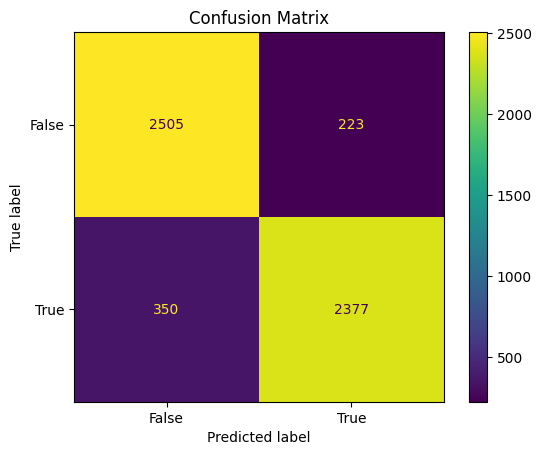

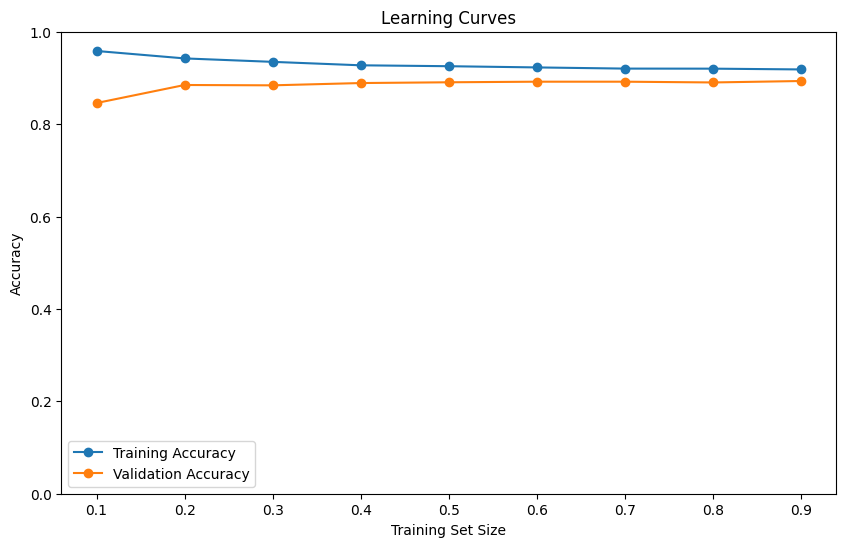

In [42]:
XGBOOST_MODEL = XGBClassifier()
XGBOOST_MODEL.fit(X_train_scaled, y_train)
pred = XGBOOST_MODEL.predict(X_test_scaled)
model_evaluation("XGBOOST CLASSIFIER", y_test, pred)
learning_curves(XGBOOST_MODEL)

In [43]:
# Hyperparameter tuning with scaled data

param_grids = {
    'SVC': {
        'model': SVC(),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.1, 1, 10],
            'solver': ['liblinear', 'lbfgs']
        }
    },
    'XGBClassifier': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    }
}

best_models = {}
for model_name, config in param_grids.items():
    grid_search = GridSearchCV(estimator=config['model'], param_grid=config['params'], cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train_scaled, y_train)
    best_models[model_name] = {
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_,
        'best_score': grid_search.best_score_
    }
    print(f"Best Parameters for {model_name}:", grid_search.best_params_)
    print(f"Best Cross-Validation Score for {model_name}:", grid_search.best_score_)

for model_name, model_info in best_models.items():
    best_model = model_info['best_estimator']
    y_pred = best_model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Set Accuracy for {model_name}: {accuracy}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters for SVC: {'C': 10, 'kernel': 'linear'}
Best Cross-Validation Score for SVC: 0.9045333255138844
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters for LogisticRegression: {'C': 1, 'solver': 'liblinear'}
Best Cross-Validation Score for LogisticRegression: 0.906105312543888
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters for XGBClassifier: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
Best Cross-Validation Score for XGBClassifier: 0.8998978944590459
Test Set Accuracy for SVC: 0.9072410632447296
Test Set Accuracy for LogisticRegression: 0.9076076993583868
Test Set Accuracy for XGBClassifier: 0.8964252978918423


Models perform slightly better with normalization.

# Final Models

========= SVM CLASSIFIER EVALUATION =========
Accuracy: 0.906141154903758
Precision: 0.9428228708516594
Recall: 0.8646864686468647
f1_score: 0.9020657995409336


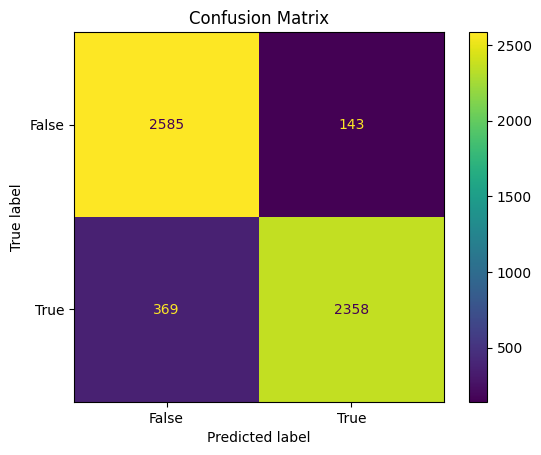

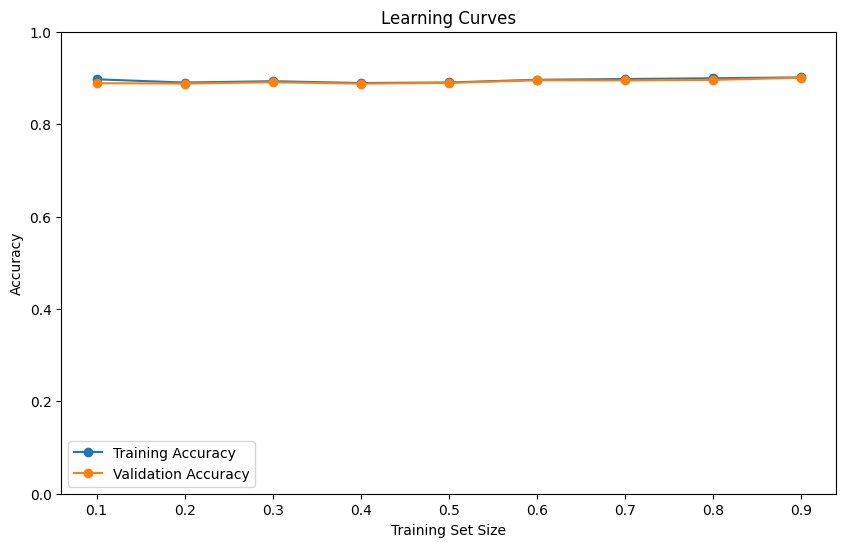

In [44]:
SVM = SVC(C=1, kernel='poly')
SVM.fit(X_train_scaled, y_train)
pred = SVM.predict(X_test_scaled)
model_evaluation("SVM Classifier", y_test, pred)
learning_curves(SVM)

========= LOGISTIC REGRESSION EVALUATION =========
Accuracy: 0.9065077910174152
Precision: 0.9362455726092089
Recall: 0.8723872387238724
f1_score: 0.9031890660592253


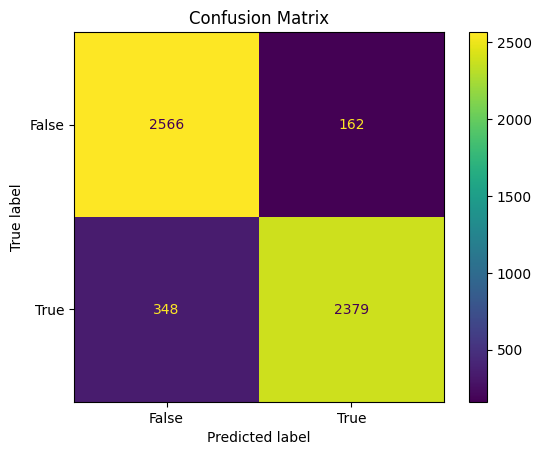

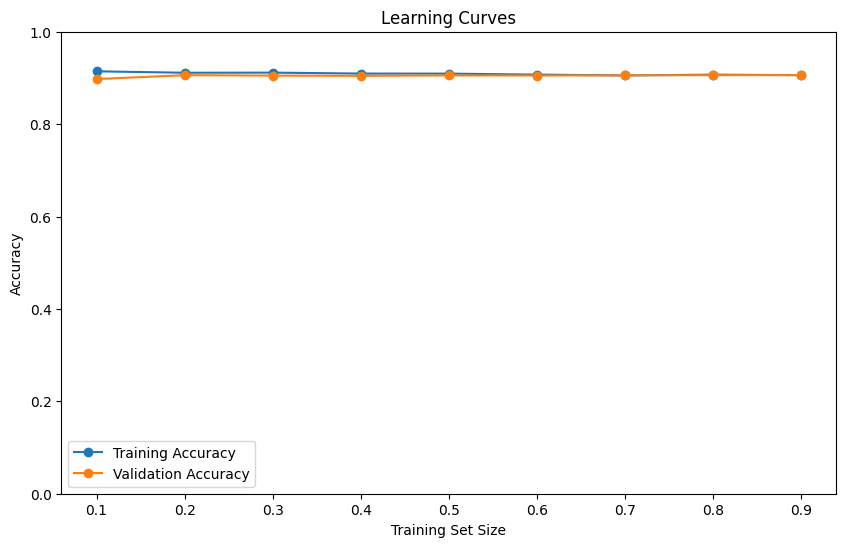

In [45]:
LogisticReg = LogisticRegression(C=10, solver='liblinear')
LogisticReg.fit(X_train_scaled, y_train)
pred = LogisticReg.predict(X_test_scaled)
model_evaluation("Logistic Regression", y_test, pred)
learning_curves(LogisticReg)

========= XGBOOST CLASSIFIER EVALUATION =========
Accuracy: 0.9026581118240147
Precision: 0.92890625
Recall: 0.8720205353868721
f1_score: 0.899564970682807


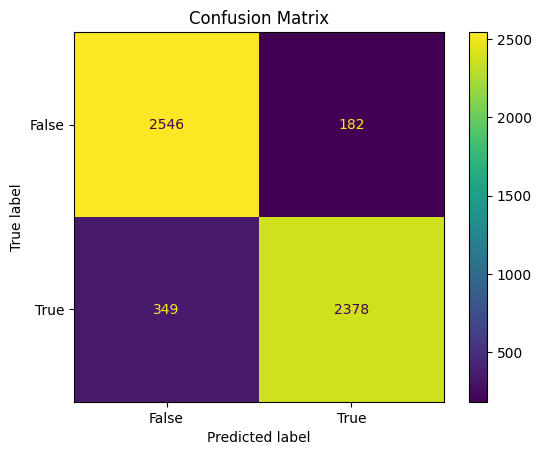

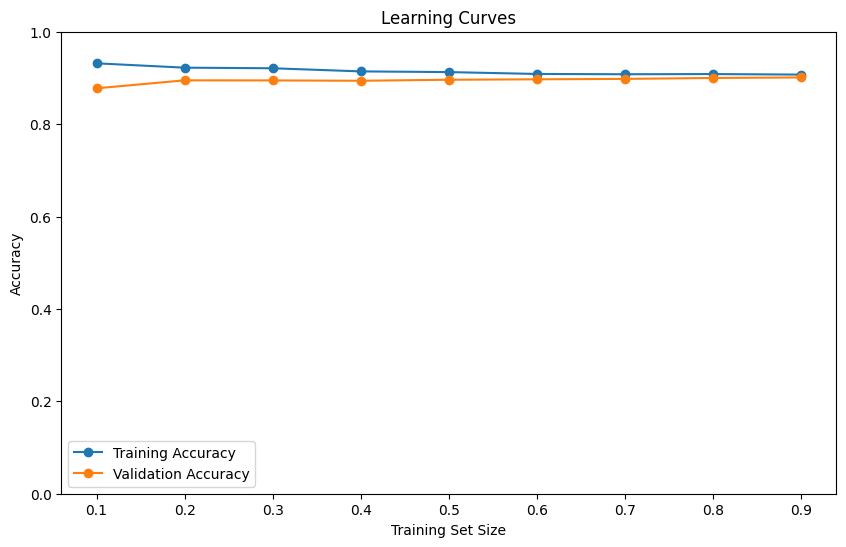

In [46]:
XGBOOST_MODEL = XGBClassifier(learning_rate=0.2, max_depth=3, n_estimators=200)
XGBOOST_MODEL.fit(X_train_scaled, y_train)
pred = XGBOOST_MODEL.predict(X_test_scaled)
model_evaluation("XGBOOST CLASSIFIER", y_test, pred)
learning_curves(XGBOOST_MODEL)

In [47]:
def save_model(model, name):
  file = open(name+'.pickle', "wb")
  pkl.dump(model, file)
  file.close()

In [48]:
save_model(SVM, 'SVC')
save_model(LogisticReg, 'LogisticReg')
save_model(XGBOOST_MODEL, 'XGBoost')
save_model(scaler, "SCALER")